# 局所学習則による最適フィードバック制御

Neural optimal feedback control with local learning rules

システム同定と同時にpolicy gradientを計算する．
- https://github.com/j-friedrich/neuralOFC/blob/master/ofc.py

   

In [ ]:
class System:
    """Class implementing the LQG problem defined by the provided arguments
    Upon initialzation the optimal solution is obtained by running the Riccati equations
    and stored as instance attributes L, P, K, S
    Parameters
    ----------
    A : ndarray, shape (m,m)
        state-transition model
    B : ndarray, shape (m,k)
        control-input model
    C : ndarray, shape (n,m)
        observation model
    V : ndarray, shape (m,m)
        covariance of process noise
    W : ndarray, shape (n,n)
        covariance of observation noise
    Q : ndarray, shape (m,m) [or (T, m, m) if time-dependent]
        matrix in x-dependent part of cost function x'Qx
    R : ndarray, shape (k,k)
        matrix in u-dependent part of cost function u'Ru
    T : int
        episode length, including 0, i.e. t = 0,...,T-1
    P0: ndarray, shape (m,m)
        initial (a priori) estimate covariance
    """

    def __init__(self, A, B, C, V, W, Q, R, T, P0=0):
        self.A, self.B, self.C, self.V, self.W, self.Q, self.R, self.T = A, B, C, V, W, Q, R, T
        self.cholV = np.linalg.cholesky(V)
        self.cholW = np.linalg.cholesky(W)
        self.n, self.m = C.shape  # observed, latent dim
        self.L, self.P, self.K, self.S = Riccati(A, B, C, V, W, Q, R, T, P0)

def PGwithSysID(self, seed, eta=3e-3, etaK=2.2e-6, momentum=.99, sigma=.2, delay=1,
                    episodes=1000, x0=[-1, 0], ABCLhat=None, Khat=None, returnX=False,
                    episodes2=1000, EMAcoeff=1, multiplicative_noise=False):
     """Perform system identification, i.e. learning of A,B,C,L,
           simultaneously with cost minimization using policy gradient method GPOMDP
        Parameters
        ----------
        seed : int
            random seed
        eta : float or 4-tuple of floats
            learning rate(s) for filter weigths A,B,C,L
        etaK : float
            learning rate for control weigths K
        momentum : float
            Momentum [0,1) for control weigths K
        sigma : float
            standard deviation of the Gaussian noise of the actor
        delay : int
            amount of measurement delay
        episodes : int
            number of episodes
        x0 : m-tuple or tuple of m-tuples
            initial position(s); looped over if multiple are provided
        ABCLhat : tuple of ndarrays with shapes ((m,m), (m,k), (n,m), (m,n))
            The initial estimates for weight matrices A, B, C, and L.
        Khat : ndarray, shape (k,m)
            initial estimates for control weight matrix K
        returnX : bool
            whether to return all trajectories executed during training
        episodes2 : int
            number of episodes run after training without noise in actor
        EMAcoeff : float
            coefficient of exponential moving average for reward baseline in PG gradient estimate
        Returns
        -------
        J, J2, mse, Ahat, Bhat, Chat, Lhat, Khat [, Xs]
            J   costs for each episode during training
            J2  costs after training for running episodes2 episodes without noise in actor
            mse  mean squared errors for each episode
            Ahat, Bhat, Chat, Lhat, Khat  final weight matrices after training
            Xs  trajectories for each episode
        """
        A, B, C, Q, R, T = self.A, self.B, self.C, self.Q, self.R, self.T
        cholV, cholW = self.cholV, self.cholW
        n, m = C.shape
        if Khat is None:
            Khat = np.zeros((1, m))
        else:
            Khat = Khat.copy()
        etaA, etaB, etaC, etaL = [eta] * 4 if isinstance(eta, (int, float)) else eta
        np.random.seed(seed)
        if ABCLhat is None:
            Ahat, Bhat, Chat, Lhat = [.1*np.random.randn(*a_.shape) for a_ in (A, B, C, C.T)]
        elif type(ABCLhat) == str:
            Ahat, Bhat, Chat, Lhat = eval(ABCLhat)
        else:
            Ahat, Bhat, Chat, Lhat = deepcopy([a.astype(float) for a in ABCLhat])
        mse = []
        X = np.zeros((T, m))
        U = np.zeros((T-1, B.shape[1]))
        Y = np.zeros((T, n))
        X[0] = x0 if len(np.shape(x0)) == 1 else x0[seed % len(x0)]
        Y[0] = C.dot(X[0])
        Xhat = X.copy()
        J = []
        grad = np.zeros(B.T.shape)
        if returnX:
            Xs = np.empty((episodes, T, m))
        avgJ = 0
        for j in range(episodes):
            Xhat = np.zeros((T, m))
            U = np.zeros((T-1, B.shape[1]))
            if len(np.shape(x0)) == 2:
                X[0] = x0[j % len(x0)]
                Y[0] = C.dot(X[0])
            Xhat[0] = np.linalg.lstsq(Chat, Y[0], rcond=None)[0]
            z = np.zeros(grad.shape)
            e = np.zeros((1+delay, n))
            for t in range(T-1):
                xi = sigma*np.random.randn(B.shape[1])
                U[t] = -Khat.dot(Xhat[t]) + xi
                z += np.outer(xi, Xhat[t])
                noise = cholV.dot(np.random.randn(m))
                if multiplicative_noise:
                    noise *= np.sqrt(U[t].dot(U[t])) * 200
                X[t+1] = A.dot(X[t]) + B.dot(U[t]) + noise
                Y[t+1] = C.dot(X[t+1]) + cholW.dot(np.random.randn(n))
                e[1:] = e[:-1]
                td = t-delay+1
                if td >= 0:
                    e[0] = Y[td] - Chat.dot(Xhat[td])
                Le = Lhat.dot(e[0])
                Xhat[t+1] = Ahat.dot(Xhat[t]) + Bhat.dot(U[t]) + Le

                Ahat += etaA*np.outer(Le, Xhat[t-delay])
                Bhat += etaB*np.outer(Le, U[t-delay])
                Lhat += etaL*np.outer(Le, e[-1])
                Chat += etaC*np.outer(e[0], Xhat[t+1-delay])

                cost = X[t+1].dot(Q).dot(X[t+1]) + U[t].dot(R).dot(U[t]) - avgJ
                grad = momentum*grad + cost * z
                Khat += etaK * grad
            J.append(np.trace(X.T.dot(X).dot(Q)) + np.trace(U.T.dot(U).dot(R)))
            if EMAcoeff != 1:
                avgJ = EMAcoeff*avgJ + (1-EMAcoeff)*J[-1]/T
            e = Y-Xhat.dot(Chat.T)
            mse.append(np.trace(e.T.dot(e))/T)
            if returnX:
                Xs[j] = X
        J2 = []
        Xhat[0] = np.linalg.lstsq(Chat, Y[0], rcond=None)[0]
        for _ in range(episodes2):
            e = np.zeros((1+delay, n))
            for t in range(T-1):
                U[t] = -Khat.dot(Xhat[t])
                noise = cholV.dot(np.random.randn(m))
                if multiplicative_noise:
                    noise *= np.sqrt(U[t].dot(U[t])) * 200
                X[t+1] = A.dot(X[t]) + B.dot(U[t]) + noise
                Y[t+1] = C.dot(X[t+1]) + cholW.dot(np.random.randn(n))
                e[1:] = e[:-1]
                td = t-delay+1
                if td >= 0:
                    e[0] = Y[td] - Chat.dot(Xhat[td])
                Xhat[t+1] = Ahat.dot(Xhat[t]) + Bhat.dot(U[t]) + Lhat.dot(e[0])
            J2.append(np.trace(X.T.dot(X).dot(Q)) + np.trace(U.T.dot(U).dot(R)))
        if returnX:
            return J, J2, mse, Ahat, Bhat, Chat, Lhat, Khat, Xs
        else:
            return J, J2, mse, Ahat, Bhat, Chat, Lhat, Khat

### 系の状態変化

$$
\begin{aligned}
&\text {Dynamics} \quad \mathbf{x}_{t+1}=A \mathbf{x}_{t}+B \mathbf{u}_{t}+\boldsymbol{\xi}_{t}+\sum_{i=1}^{c} \varepsilon_{t}^{i} C_{i} \mathbf{u}_{t}\\
&\text {Feedback} \quad \mathbf{y}_{t}=H \mathbf{x}_{t}+\omega_{t}+\sum_{i=1}^{d} \epsilon_{t}^{i} D_{i} \mathbf{x}_{t}\\
&\text{Cost per step}\quad \mathbf{x}_{t}^\top Q_{t} \mathbf{x}_{t}+\mathbf{u}_{t}^\top R \mathbf{u}_{t}
\end{aligned}
$$

### LQG
加法ノイズしかない場合($C=D=0$)，制御問題は**線形2次ガウシアン(LQG: linear-quadratic-Gaussian)制御**と呼ばれる．


#### 運動制御 (Linear-Quadratic Regulator)

$$
\begin{align}
\mathbf{u}_{t}&=-L_{t} \widehat{\mathbf{x}}_{t}\\
L_{t}&=\left(R+B^{\top} S_{t+1} B\right)^{-1} B^{\top} S_{t+1} A\\
S_{t}&=Q_{t}+A^{\top} S_{t+1}\left(A-B L_{t}\right)\\
s_t &= \mathrm{tr}(S_{t+1}\Omega^\xi) + s_{t+1}; s_T=0
\end{align}
$$

$\boldsymbol{S}_{T}=Q$

#### 状態推定 (Kalman Filter)

$$
\begin{align}
\widehat{\mathbf{x}}_{t+1}&=A \widehat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \widehat{\mathbf{x}}_{t}\right)+\boldsymbol{\eta}_{t} \\ 
K_{t}&=A \Sigma_{t} H^{\top}\left(H \Sigma_{t} H^{\top}+\Omega^{\omega}\right)^{-1} \\ 
\Sigma_{t+1}&=\Omega^{\xi}+\left(A-K_{t} H\right) \Sigma_{t} A^{\top}
\end{align}
$$

この場合に限り，運動制御と状態推定を独立させることができる．

### 一般化LQG
状態および制御依存ノイズがある場合，

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

- ToDo: struct 修正（nが両方に入っている）

In [2]:
@kwdef struct Reaching1DModelParameter
    n = 4 # number of dims
    p = 3 # 
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(p) I(p); -[0, α1, α2, α3]']
    B = [zeros(p); bu]
    C = [I(p) zeros(p)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)
end

@kwdef struct Reaching1DModelCostParameter
    n = 4
    dt = 1e-2 # sec
    T = 0.5 # sec
    nt = round(Int, T/dt) # num time steps
    Q = [zeros(nt-1, n, n); reshape(Diagonal([1.0, 0.1, 1e-3, 1e-4]), (1, n, n))]
    R = 1e-4 / nt
    
    init_pos = -0.5
    x₁ = [init_pos; zeros(n-1)]#zeros(n)
    Σ₁ = zeros(n, n)
end

Reaching1DModelCostParameter

Qの値は各時刻において一般座標 (位置，速度，加速度，躍度)のそれぞれを0にするコストに対する重みづけである．例えば，速度も0にすることを重視すれば2番目の係数を上げる．

$S$と$\Sigma$は各時点での値を一時的にしか必要としないので更新する．

In [3]:
function LQG(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter)
    @unpack n, p, A, B, C, D, G = param
    @unpack Q, R, x₁, Σ₁, dt, nt = cost_param

    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = copy(Q[end, :, :]) # S_T = Q
    Σ = copy(Σ₁);

    for t in 1:nt-1
        K[t, :, :] = A * Σ * C' / (C * Σ * C' + D) # update K
        Σ = G + (A - K[t, :, :] * C) * Σ * A'      # update Σ
    end　

    cost = 0
    for t in nt-1:-1:1
        cost += tr(S * G)
        L[t, :] = (R + B' * S * B) \ B' * S * A # update L
        S = Q[t, :, :] + A' * S * (A - B * L[t, :]')     # update S
    end
    
    # adjust cost
    cost += x₁' * S * x₁
    return L, K, cost
end

LQG (generic function with 1 method)

In [5]:
function simulation(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter, 
                    L, K; noisy=false)
    @unpack n, p, A, B, C, D, Y, G = param
    @unpack Q, R, x₁, dt, nt = cost_param
    
    X = zeros(n, nt)
    u = zeros(nt)
    X[:, 1] = x₁ # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L[t, :]' * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K[t, :, :] * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L[t, :]' * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 1 method)

In [6]:
function simulation_all(param, cost_param, L, K)
    Xa, ua = simulation(param, cost_param, L, K, noisy=false);
    
    # noisy
    nsim = 10
    XSimAll = []
    uSimAll = []
    for i in 1:nsim
        XSim, u = simulation(param, cost_param, L, K, noisy=true);
        push!(XSimAll, XSim)
        push!(uSimAll, u)
    end
    
    # visualization
    @unpack dt, T = cost_param
    tarray = collect(dt:dt:T)
    label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

    fig, ax = subplots(1, 3, figsize=(10, 3))
    for i in 1:2
        for j in 1:nsim
            ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
        end

        ax[i].plot(tarray, Xa[i,:], "tab:red")
        ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); 
        ax[i].set_xlim(0, T); ax[i].grid()
    end

    for j in 1:nsim
        ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
    end
    ax[3].plot(tarray, ua, "tab:red")
    ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); 
    ax[3].set_xlim(0, T); ax[3].grid()

    tight_layout()
end

simulation_all (generic function with 1 method)

In [7]:
param = Reaching1DModelParameter()
cost_param = Reaching1DModelCostParameter();

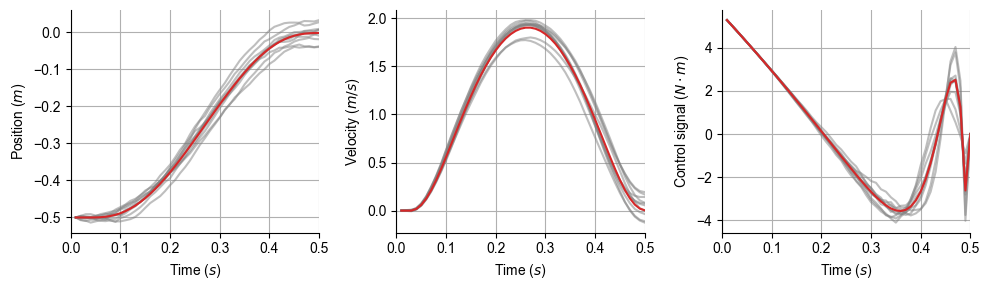

In [8]:
L, K, cost = LQG(param, cost_param);
simulation_all(param, cost_param, L, K)

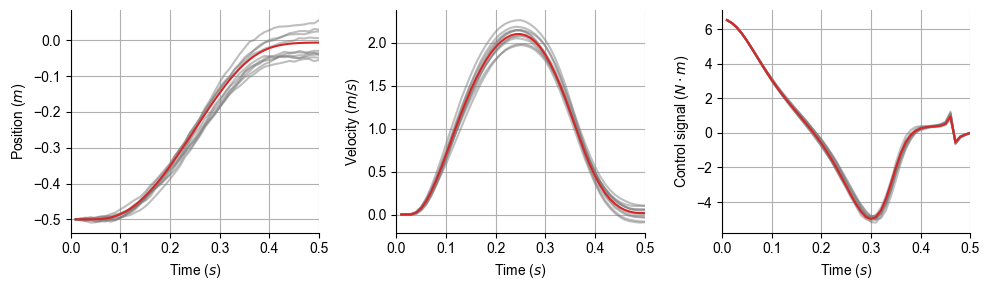

In [9]:
L, K, cost = gLQG(param, cost_param);
simulation_all(param, cost_param, L, K)

## 参考文献
```{bibliography}
:filter: docname in docnames
```